# Behavioral analyses

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from utils import *
from fit_psychometric import PsychometricRegression, fit_psychometric, cumulative_gaussian, weibull

#temp workaround since it gets removed from the path whenever the kernel is restarted
import sys
sys.path.insert(0, '/Users/gabriel/lib/')
import chiCa

%matplotlib widget
import matplotlib
matplotlib.rcParams['savefig.format'] = 'pdf'

## Define some WIP functions

In [2]:
def get_session_dates(file_names):
    session_dates = []
    for file in file_names:
        split_path = file.split('/')
        session_dates.append(split_path[5]) #with the churchland data folder structure, this corresponds to the date

    return session_dates

def get_session_averages(file_names, min_stims=5):
    session_performance_averages = []
    for file in file_names: 
        session_data = pd.read_hdf(file)
        stim_rates = np.unique(np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps]))
        if len(stim_rates)>min_stims:
            performance = np.array(session_data.outcome_record, dtype=float)
            performance[performance == -1] = np.nan #setting early withdrawal trials as nans
            performance[performance == 2] = np.nan #setting no response trials as nans
            session_performance_averages.append(np.nanmean(performance))

    return session_performance_averages

def get_session_trial_counts(file_names):
    session_trial_counts = []
    for file in file_names: 
        session_data = pd.read_hdf(file)
        ntrials = len(session_data)
        session_trial_counts.append(ntrials)

    return session_trial_counts

def get_filtered_session_averages_and_dates(file_names, min_stims=5):
    filtered_dates = []
    filtered_session_averages = []
    stims = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
        unique_stims = list(np.unique(stim_rates))
        valid_trials = np.logical_or(stim_rates == 4, stim_rates == 20)
        if len(unique_stims)>min_stims:
            #allocate performance
            performance = np.array(session_data.outcome_record, dtype=float)
            performance[performance == -1] = np.nan #setting early withdrawal trials as nans
            performance[performance == 2] = np.nan #setting no response trials as nans
            filtered_session_averages.append(np.nanmean(performance[valid_trials]))

            #allocate date
            split_path = file.split('/')
            filtered_dates.append(split_path[5])

            #allocate unique_stims
            stims.append(unique_stims)

    return filtered_dates, filtered_session_averages, stims

def get_median_wait_time(file_names):
    median_wait_times = []
    for file in file_names:
        session_data = pd.read_hdf(file)
        median_wait_times.append(np.nanmedian(session_data.waitTime))

    return median_wait_times

def get_file_names(animal_name, data_type, file_extension, file_keyword=None):
    '''Tool to select specified files of a data type over all sessions for a given animal.
    This relies on the hierarchical Churchland lab data folder structure with:
    animal_name -> session_datetime -> data_type
    
    Adapted from Lukas Oesch's `chipmunk_analysis_tools.py`.
       
    
    Parameters
    ----------
    animal_name: str, the name of the animal whose sessions are to be selected.
    data_type: str, the directory with the specific data type, for example chipumnk, caiman, etc.
    file_extension: str, file extension specifier, for example *.mat
    file_keyword: str, a pattern that should be detected inside the file name to
                  distinguish the desired files from other files with the same extension.
    
    Returns
    -------
    file_names: list, list of file names selected
    
    Examples
    --------
    file_names = get_file_names('GRB001', 'chipmunk', '*.h5')
    '''
    import os
    import glob
    
    home_dir = os.path.expanduser("~")
    session_dirs = glob.glob(f"{home_dir}/data/{animal_name}/*/")
    
    file_names = []
    for session_dir in session_dirs:
        data_type_dir = os.path.join(session_dir, data_type)
        file_paths = glob.glob(os.path.join(data_type_dir, file_extension))
        for file_path in file_paths:
            if file_keyword is None or file_keyword in file_path:
                file_names.append(file_path)
    
    file_names.sort()
    
    return file_names

def count_stimulus_timestamps(row):
    data = pd.read_hdf(row['path'])
    stimulus_event_timestamps = data['stimulus_event_timestamps']
    trial_lengths = [len(trial) for trial in stimulus_event_timestamps]
    return trial_lengths

def get_response_side(row):
    data = pd.read_hdf(row['path'])
    response_side = np.array(data['response_side'])
    return response_side

def moving_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

## Get mat files, convert them to h5 format, and store the paths to those files

In [151]:
#Get mat paths, convert them to h5 if necessary, and store h5 paths in a dictionary
animal_ids = ['GRB001', 'GRB002', 'GRB003', 'GRB004', 'GRB005', 'GRB006', 'GRB007', 'GRB008', 'GRB009', 'GRB015', 'GRB016', 'GRB017', 'GRB018']
mat_paths_all_animals = {animal_id: get_file_names(animal_id, 'chipmunk', '*.mat') for animal_id in animal_ids}
h5paths = [chiCa.convert_specified_behavior_sessions(matpaths, overwrite = False) for animalID, matpaths in mat_paths_all_animals.items()]
paths_all_animals = {animal_id: get_file_names(animal_id, 'chipmunk', '*.h5') for animal_id in animal_ids}

File: GRB001_20230126_110314_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB001_20230127_114504_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB001_20230130_121533_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB001_20230131_113044_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB001_20230201_131437_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file e

/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:223: UserWarning: CUATON: An error occured and /Users/gabriel/data/GRB003/20230127_152241/chipmunk/GRB003_20230127_152241_chipmunk_DemonstratorAudiTask.mat could not be converted
  warnings.warn(f"CUATON: An error occured and {current_file} could not be converted")
/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:223: UserWarning: CUATON: An error occured and /Users/gabriel/data/GRB005/20230811_132026/chipmunk/GRB005_20230811_132026_chipmunk_DemonstratorAudiTask.mat could not be converted
  warnings.warn(f"CUATON: An error occured and {current_file} could not be converted")
/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:223: UserWarning: CUATON: An error occured and /Users/gabriel/data/GRB005/20230830_140210/chipmunk/GRB005_20230830_140210_chipmunk_DemonstratorAudiTask.mat could not be converted
  warnings.warn(f"CUATON: An error occured and {current_file} could not be converted")
/Users/gabriel/lib/chiCa/chipmunk_analysis_too

File: GRB006_20230808_130746_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB006_20230809_145119_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB006_20230810_135506_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB006_20230811_144600_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB006_20230814_145927_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file e

/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:223: UserWarning: CUATON: An error occured and /Users/gabriel/data/GRB006/20240110_144905/chipmunk/GRB006_20240110_144905_chipmunk_DemonstratorAudiTask.mat could not be converted
  warnings.warn(f"CUATON: An error occured and {current_file} could not be converted")
/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:113: UserWarning: Found multisensory trials, assumed synchronous condition
  warnings.warn('Found multisensory trials, assumed synchronous condition')
/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:219: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['Port1In', 'Port1Out', 'Port2In', 'Port2Out', 'Port3In', 'Port3Out',
       'Tup', 'DemonCenterFixationPeriod', 'DemonDidNotChoose',
       'DemonEarlyWithdrawal', 'DemonEarlyWithdrawalPunishment', 'DemonGoCue',
       'DemonInitFixation', 

File: GRB009_20230818_143846_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB009_20230822_143339_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB009_20230823_150335_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB009_20230825_163903_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB009_20230828_121637_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file e

/Users/gabriel/lib/chiCa/chipmunk_analysis_tools.py:219: PerformanceWarning: 
your performance may suffer as PyTables will pickle object types that it cannot
map directly to c-types [inferred_type->mixed,key->block3_values] [items->Index(['Port1In', 'Port1Out', 'Port2In', 'Port2Out', 'Port3In', 'Port3Out',
       'Tup', 'DemonCenterFixationPeriod', 'DemonDidNotChoose',
       'DemonEarlyWithdrawal', 'DemonEarlyWithdrawalPunishment', 'DemonGoCue',
       'DemonInitFixation', 'DemonReward', 'DemonWaitForCenterFixation',
       'DemonWaitForResponse', 'DemonWaitForWithdrawalFromCenter',
       'DemonWrongChoice', 'DemonWrongChoicePunishment', 'FinishTrial',
       'PlayStimulus', 'PreStimPeriod', 'Sync', 'TrialStart',
       'stimulus_modality', 'stimulus_event_timestamps', 'demonstrator_ID',
       'outcome_presentation', 'response_port_out'],
      dtype='object')]

  trialdata.to_hdf(os.path.splitext(current_file)[0] + '.h5', '/Data') #Save as hdf5
/Users/gabriel/lib/chiCa/chipmunk_ana

File: GRB018_20231127_155614_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB018_20231128_165139_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB018_20231130_161338_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB018_20231201_164947_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file exists already.
---------------------------------------------------------------------------------------------------
File: GRB018_20231208_150737_chipmunk_DemonstratorAudiTask.mat was skipped because a corresponding h5 file e

## Get session performance, wait times, and trial count data grouped across mice

In [4]:
group_performance_data = {}
median_wait_times = {}
session_trial_counts = {}

for animalID, paths in paths_all_animals.items():
    session_dates, session_averages, unique_stims = get_filtered_session_averages_and_dates(paths, min_stims=1)
    performance_by_day = pd.DataFrame(data={'date':session_dates,'performance average':session_averages, 'unique stims':unique_stims})
    group_performance_data[animalID] = performance_by_day
    median_wait_times[animalID] = get_median_wait_time(paths)
    session_trial_counts[animalID] = get_session_trial_counts(paths)

/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_5341/2178669134.py:45: RuntimeWarning: Mean of empty slice
  filtered_session_averages.append(np.nanmean(performance[valid_trials]))
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_5341/2178669134.py:45: RuntimeWarning: Mean of empty slice
  filtered_session_averages.append(np.nanmean(performance[valid_trials]))
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_5341/2178669134.py:45: RuntimeWarning: Mean of empty slice
  filtered_session_averages.append(np.nanmean(performance[valid_trials]))
/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_5341/2178669134.py:45: RuntimeWarning: Mean of empty slice
  filtered_session_averages.append(np.nanmean(performance[valid_trials]))


## Plot average performance and median wait time per session per cohort

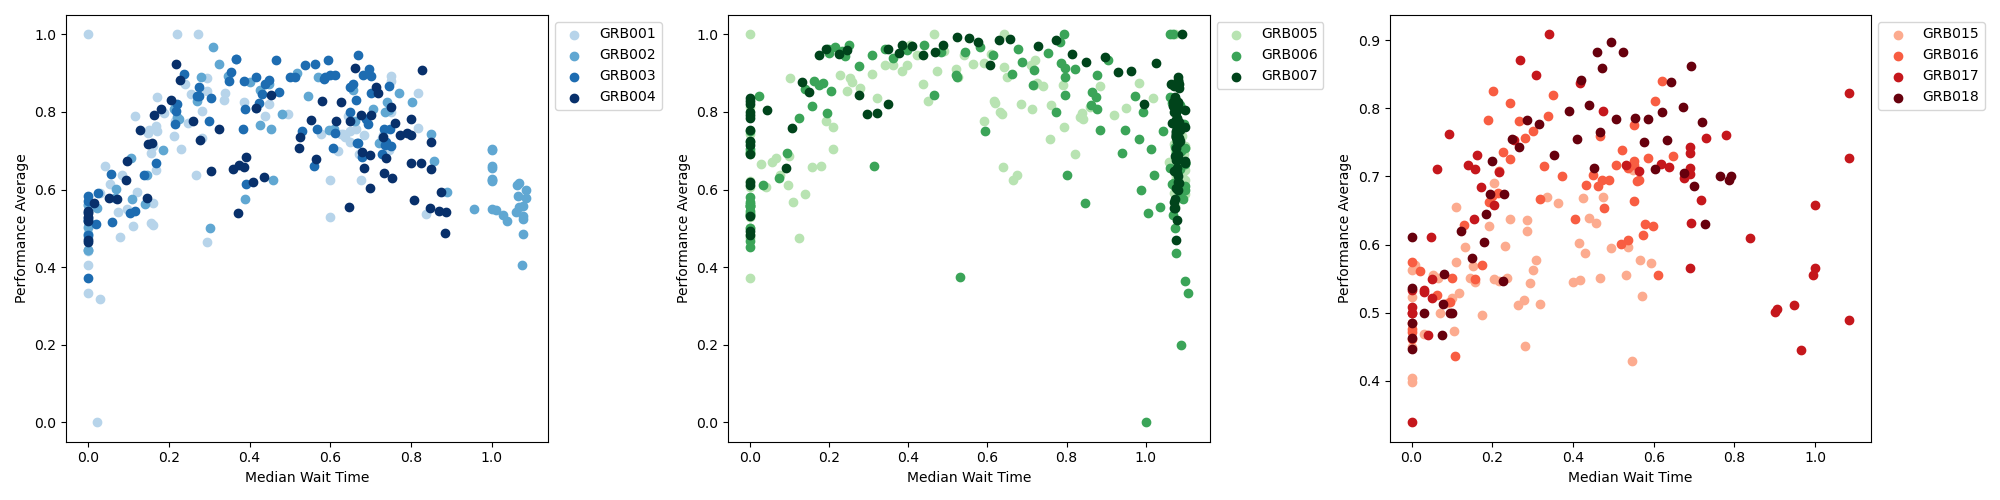

In [5]:
fig, axs = plt.subplots(1, 3, figsize=(20, 5))

group1 = ['GRB001', 'GRB002', 'GRB003', 'GRB004']
group2 = ['GRB005', 'GRB006', 'GRB007']
group3 = ['GRB015', 'GRB016', 'GRB017', 'GRB018']

# Define a list of colors for each group
colors1 = plt.cm.Blues(np.linspace(0.3, 1, len(group1)))
colors2 = plt.cm.Greens(np.linspace(0.3, 1, len(group2)))
colors3 = plt.cm.Reds(np.linspace(0.3, 1, len(group3)))

# Group 1: GRB001-GRB004
for i, animal in enumerate(group1):
    ses_performance_avg = group_performance_data[animal]['performance average']
    ses_median_waittime = median_wait_times[animal]
    if len(ses_median_waittime) == len(ses_performance_avg):
        axs[0].scatter(ses_median_waittime, ses_performance_avg, color=colors1[i], label=animal)
axs[0].set_xlabel('Median Wait Time')
axs[0].set_ylabel('Performance Average')
axs[0].legend(loc='upper left', bbox_to_anchor=(1,1))

# Group 2: GRB005-GRB007
for i, animal in enumerate(group2):
    ses_performance_avg = group_performance_data[animal]['performance average']
    ses_median_waittime = median_wait_times[animal]
    if len(ses_median_waittime) == len(ses_performance_avg):
        axs[1].scatter(ses_median_waittime, ses_performance_avg, color=colors2[i], label=animal)
axs[1].set_xlabel('Median Wait Time')
axs[1].set_ylabel('Performance Average')
axs[1].legend(loc='upper left', bbox_to_anchor=(1,1))

# Group 3: GRB015-GRB018
for i, animal in enumerate(group3):
    ses_performance_avg = group_performance_data[animal]['performance average']
    ses_median_waittime = median_wait_times[animal]
    if len(ses_median_waittime) == len(ses_performance_avg):
        axs[2].scatter(ses_median_waittime, ses_performance_avg, color=colors3[i], label=animal)
axs[2].set_xlabel('Median Wait Time')
axs[2].set_ylabel('Performance Average')
axs[2].legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()
# plt.savefig("/Users/gabriel/Library/CloudStorage/GoogleDrive-grojasbowe@gmail.com/My Drive/UCLA/ChurchlandLab/lab_meetings/figures/medianwaittime_vs_performance.pdf", format='pdf')


## Plot trial counts per session per cohort

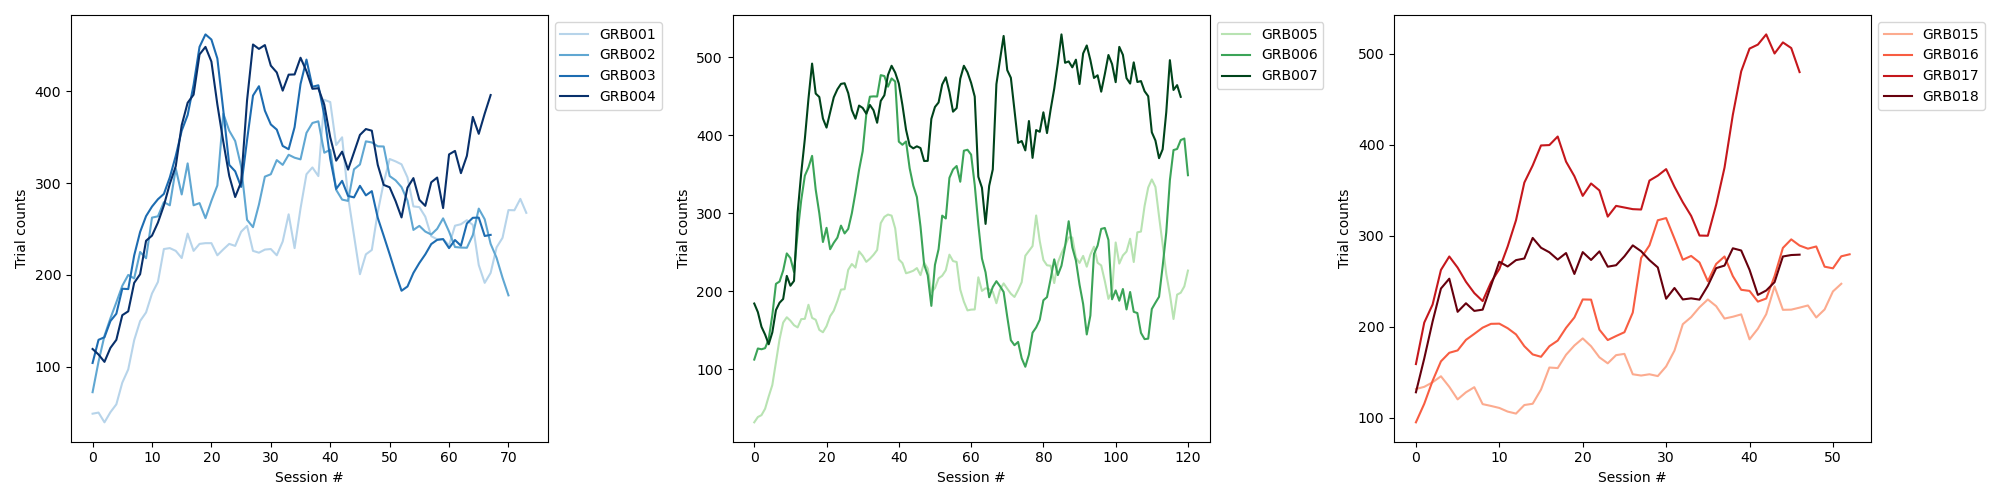

In [6]:
window_size = 5  #trials to smooth over

fig, axs = plt.subplots(1, 3, figsize=(20, 5))

# Group 1: GRB001-GRB004
for i, animal_name in enumerate(group1):
    trial_counts = session_trial_counts[animal_name]
    smoothed_counts = moving_average(trial_counts, window_size)
    axs[0].plot(smoothed_counts, color=colors1[i], label=animal_name)
axs[0].set_xlabel('Session #')
axs[0].set_ylabel('Trial counts')
axs[0].legend(loc='upper left', bbox_to_anchor=(1,1))

# Group 2: GRB005-GRB007
for i, animal_name in enumerate(group2):
    trial_counts = session_trial_counts[animal_name]
    smoothed_counts = moving_average(trial_counts, window_size)
    axs[1].plot(smoothed_counts, color=colors2[i], label=animal_name)
axs[1].set_xlabel('Session #')
axs[1].set_ylabel('Trial counts')
axs[1].legend(loc='upper left', bbox_to_anchor=(1,1))

# Group 3: GRB015-GRB018
for i, animal_name in enumerate(group3):
    trial_counts = session_trial_counts[animal_name]
    smoothed_counts = moving_average(trial_counts, window_size)
    axs[2].plot(smoothed_counts, color=colors3[i], label=animal_name)
axs[2].set_xlabel('Session #')
axs[2].set_ylabel('Trial counts')
axs[2].legend(loc='upper left', bbox_to_anchor=(1,1))

plt.tight_layout()
plt.show()


## Plot session performance on easy stimuli over days on top of the median wait times for those days

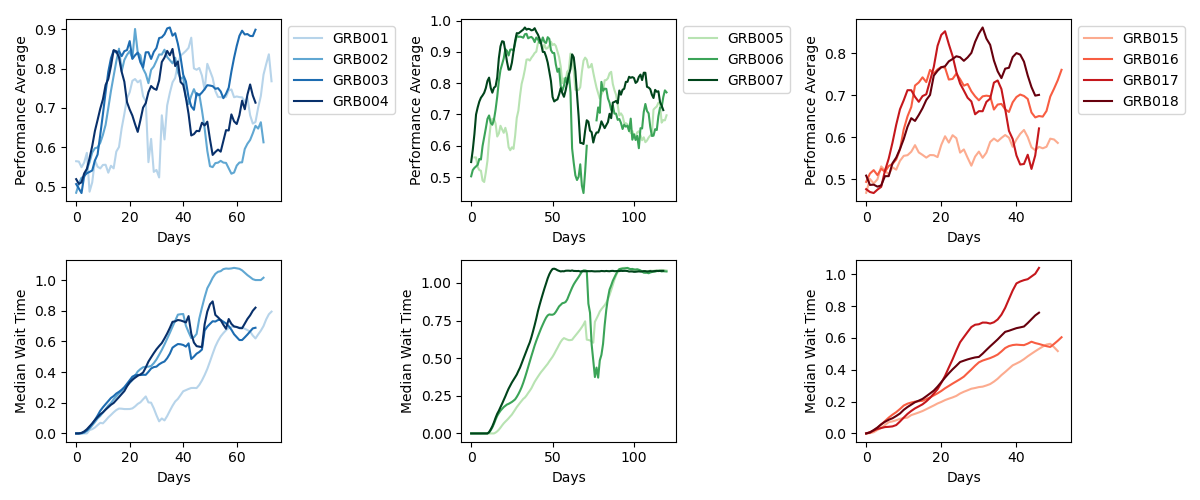

In [7]:
fig, axs = plt.subplots(2, 3, figsize=(12, 5))

window_size = 5  #trials to smooth over

# Group 1: GRB001-GRB004
for i, animal in enumerate(group1):
    ses_performance_avg = group_performance_data[animal]['performance average']
    smoothed_perf = moving_average(ses_performance_avg, window_size)
    axs[0,0].plot(smoothed_perf, color=colors1[i], label=animal)
axs[0,0].set_xlabel('Days')
axs[0,0].set_ylabel('Performance Average')
axs[0,0].legend(loc='upper left', bbox_to_anchor=(1,1))

# Group 2: GRB005-GRB007
for i, animal in enumerate(group2):
    ses_performance_avg = group_performance_data[animal]['performance average']
    smoothed_perf = moving_average(ses_performance_avg, window_size)
    axs[0,1].plot(smoothed_perf, color=colors2[i], label=animal)
axs[0,1].set_xlabel('Days')
axs[0,1].set_ylabel('Performance Average')
axs[0,1].legend(loc='upper left', bbox_to_anchor=(1,1))

# Group 3: GRB015-GRB018
for i, animal in enumerate(group3):
    ses_performance_avg = group_performance_data[animal]['performance average']
    smoothed_perf = moving_average(ses_performance_avg, window_size)
    axs[0,2].plot(smoothed_perf, color=colors3[i], label=animal)
axs[0,2].set_xlabel('Days')
axs[0,2].set_ylabel('Performance Average')
axs[0,2].legend(loc='upper left', bbox_to_anchor=(1,1))

#and now the same for the median wait time per session
for i, animal in enumerate(group1):
    ses_waittimes = median_wait_times[animal]
    smoothed_waittimes = moving_average(ses_waittimes, window_size)
    axs[1,0].plot(smoothed_waittimes, color=colors1[i], label=animal)
axs[1,0].set_xlabel('Days')
axs[1,0].set_ylabel('Median Wait Time')

for i, animal in enumerate(group2):
    ses_waittimes = median_wait_times[animal]
    smoothed_waittimes = moving_average(ses_waittimes, window_size)
    axs[1,1].plot(smoothed_waittimes, color=colors2[i], label=animal)
axs[1,1].set_xlabel('Days')
axs[1,1].set_ylabel('Median Wait Time')

for i, animal in enumerate(group3):
    ses_waittimes = median_wait_times[animal]
    smoothed_waittimes = moving_average(ses_waittimes, window_size)
    axs[1,2].plot(smoothed_waittimes, color=colors3[i], label=animal)
axs[1,2].set_xlabel('Days')
axs[1,2].set_ylabel('Median Wait Time')

plt.tight_layout()
plt.show()

## Get performance for all trials, concatenate them by animal, and store them in one dictionary

In [8]:
def get_all_trials_performance(animal_ids, file_names, min_stims=5):
    all_trials_all_animals = dict()
    for animal in animal_ids:
        trials_performance = np.array([])
        for file in file_names[animal]:
            session_data = pd.read_hdf(file)
            stim_rates = np.array([len(timestamps) for timestamps in session_data.stimulus_event_timestamps])
            unique_stims = list(np.unique(stim_rates))
            valid_trials = np.logical_or(stim_rates == 4, stim_rates == 20)
            if len(unique_stims)>=min_stims:
                #allocate performance
                performance = np.array(session_data.outcome_record, dtype=float)
                performance[performance == -1] = np.nan #setting early withdrawal trials as nans
                performance[performance == 2] = np.nan #setting no response trials as nans
                trials_performance = np.concatenate((trials_performance, performance[valid_trials]))
                trials_performance = trials_performance[~np.isnan(trials_performance)] #remove nans
        all_trials_all_animals[animal] = trials_performance

    return all_trials_all_animals

animal_ids = ['GRB001', 'GRB002', 'GRB003', 'GRB004', 'GRB005', 'GRB006', 'GRB007', 'GRB008', 'GRB009', 'GRB015', 'GRB016', 'GRB017', 'GRB018']

all_trials_performance = get_all_trials_performance(animal_ids, paths_all_animals, min_stims=1)

## Plot the performance for all trials for each animal and a cohort average interactively

interactive(children=(IntSlider(value=0, description='icohort', max=2), IntSlider(value=500, description='wind…

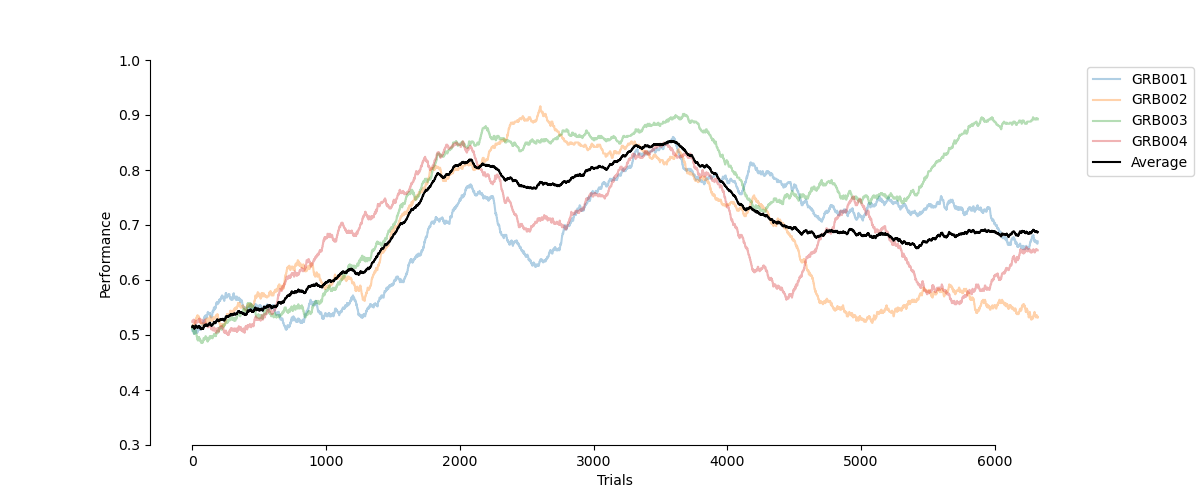

In [9]:
def separate_axes(ax): #thanks Lukas!
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    yti = ax.get_yticks()
    yti = yti[(yti >= ax.get_ylim()[0]) & (yti <= ax.get_ylim()[1]+10**-3)] #Add a small value to cover for some very tiny added values
    ax.spines['left'].set_bounds([yti[0], yti[-1]])
    xti = ax.get_xticks()
    xti = xti[(xti >= ax.get_xlim()[0]) & (xti <= ax.get_xlim()[1]+10**-3)]
    ax.spines['bottom'].set_bounds([xti[0], xti[-1]])

    return

from ipywidgets import interact, IntSlider #thanks Lillian!

fig, ax = plt.subplots(1, 1, figsize=(12, 5))

first_cohort = ['GRB001', 'GRB002', 'GRB003', 'GRB004']
second_cohort = ['GRB005', 'GRB006', 'GRB007']
third_cohort = ['GRB015', 'GRB016', 'GRB017', 'GRB018']

cohorts = [first_cohort, second_cohort, third_cohort]

@interact(icohort=IntSlider(min=0, max=len(cohorts)-1, step=1, value=0), window_size=IntSlider(min=10, max=1500, step=10, value=500), plot_avg=True)
def g(icohort, window_size, plot_avg):
    ax.clear()
    cohort = cohorts[icohort]
    filtered_cohort = {animal: all_trials_performance[animal] for animal in cohort}

    if plot_avg:
        #cutting to the minimum length for calculating the group average
        min_length = min([len(trials_performance) for animal, trials_performance in filtered_cohort.items()])
        for animal, trials_performance in filtered_cohort.items():
            filtered_cohort[animal] = trials_performance[:min_length]

        for animal, trials_performance in filtered_cohort.items():
            ax.plot(moving_average(trials_performance, window_size), alpha=0.35, label=animal)
        ax.plot(moving_average(np.array([trials_performance for animal, trials_performance in filtered_cohort.items()]).mean(axis=0), window_size), color='black', label='Average')
        ax.set_xlabel('Trials')
        ax.set_ylabel('Performance')
        ax.set_ylim(0.3, 1)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    else:
        for animal, trials_performance in filtered_cohort.items():
            ax.plot(moving_average(trials_performance, window_size), alpha=0.8, label=animal)
        ax.set_xlabel('Trials')
        ax.set_ylabel('Performance')
        ax.set_ylim(0.3, 1)
        ax.legend(loc='upper left', bbox_to_anchor=(1, 1))

    separate_axes(ax)

    return


###OLD METHOD OF GENERATING THIS FIGURES ONE BY ONE###
#----------------------------------------------------#
# def plot_all_trials_performance(animals_to_plot, all_trials_performance, plot_avg=True, window_size=500):

#     all_trials_performance = {animal: all_trials_performance[animal] for animal in animals_to_plot}
#     # print(all_trials_performance.keys())
#     fig, ax = plt.subplots(1, 1, figsize=(12, 5))

#     if plot_avg:
#         #cutting to the minimum length for calculating the group average
#         min_length = min([len(trials_performance) for animal, trials_performance in all_trials_performance.items()])
#         for animal, trials_performance in all_trials_performance.items():
#             all_trials_performance[animal] = trials_performance[:min_length]

#         for animal, trials_performance in all_trials_performance.items():
#             ax.plot(moving_average(trials_performance, window_size), alpha=0.35, label=animal)
#         ax.plot(moving_average(np.array([trials_performance for animal, trials_performance in all_trials_performance.items()]).mean(axis=0), window_size), color='black', label='Average')
#         ax.set_xlabel('Trials')
#         ax.set_ylabel('Performance')
#         ax.set_ylim(0.4, 1)
#         ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
#     else:
#         for animal, trials_performance in all_trials_performance.items():
#             ax.plot(moving_average(trials_performance, window_size), alpha=0.8, label=animal)
#         ax.set_xlabel('Trials')
#         ax.set_ylabel('Performance')
#         ax.set_ylim(0.4, 1)
#         ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
    
#     return None

# #plot with no avg
# # plot_all_trials_performance(second_cohort, paths_all_animals, min_stims=1, plot_avg=False)
# # plot_all_trials_performance(third_cohort, paths_all_animals, min_stims=1, plot_avg=False)

# #plot with avg
# plot_all_trials_performance(third_cohort, all_trials_performance, plot_avg=True)
# # plot_all_trials_performance(third_cohort, paths_all_animals, plot_avg=True)

# plt.show()
# plt.tight_layout()

## Psychometric functions averaged over sessions

In [11]:
def get_psychometric_results_all_animals(animal_ids):
    psychometric_results = dict()

    min_stim_opt = [2,4,5,6,8,10]
    stims_equal_opt = ['yes','no']

    for val in stims_equal_opt:
        if val == 'yes':
            stims_equal = True
        else:
            stims_equal = False

        for min_stim in min_stim_opt:
            if val not in psychometric_results: #initializing val (i.e. stims_equal bc python doesn't like me indexing a boolean) key if it doesn't exist yet
                psychometric_results[val] = {}
            if min_stim not in psychometric_results[val]: #initializing min_stim key if it doesn't exist yet
                psychometric_results[val][min_stim] = {}

            for animal in animal_ids:
                session_info = []
                all_stims = np.array([])
                all_choices = np.array([])
                session_files = paths_all_animals[animal]
                for session_file in session_files:
                    # all_stims = np.array([])
                    # all_choices = np.array([])
                    session_data = pd.read_hdf(session_file)
                    sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
                    responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the left side) and cast to integer datatype (number)   
                    sel_stim_rates = sel.stimulus_event_timestamps.str.len()
                    unique_stim_rates = len(np.unique(sel_stim_rates))
                    if (stims_equal and unique_stim_rates == min_stim) or (not stims_equal and unique_stim_rates >= min_stim): #if stims equal is true, checks if the session has exactly the minimum # of stim rates. if false, checks that the session's # of stim rates are equal or more than the minimum
                        all_stims = np.concatenate((all_stims, sel_stim_rates))
                        all_choices = np.concatenate((all_choices, responded_right))
                        session_info.append((all_stims, all_choices))
                
                    if all_stims.size > 0:
                        res = fit_psychometric(all_stims.astype(float),all_choices.astype(float), min_required_stim_values=min_stim)
                    else:
                        res = None

                    psychometric_results[val][min_stim][animal] = res

                # res = fit_psychometric(all_stims.astype(float),all_choices.astype(float), min_required_stim_values=min_stim)

                # psychometric_results[val][min_stim][animal] = res

    return psychometric_results

animal_ids = ['GRB001', 'GRB002', 'GRB003', 'GRB004', 'GRB005', 'GRB006', 'GRB007', 'GRB015', 'GRB016', 'GRB017', 'GRB018']

psychometric_results = get_psychometric_results_all_animals(animal_ids)


/Users/gabriel/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabriel/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabriel/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabriel/miniconda3/lib/python3.10/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/Users/gabriel/miniconda3/lib/python3.10/site-packages/statsmode

/var/folders/k4/_l1cqd4d0gn02n75d0rrj10h0000gr/T/ipykernel_5341/1082144254.py:19: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, axs = plt.subplots(1, 2, figsize=(8, 5))


interactive(children=(Checkbox(value=False, description='stims_equal'), IntSlider(value=6, description='ianima…

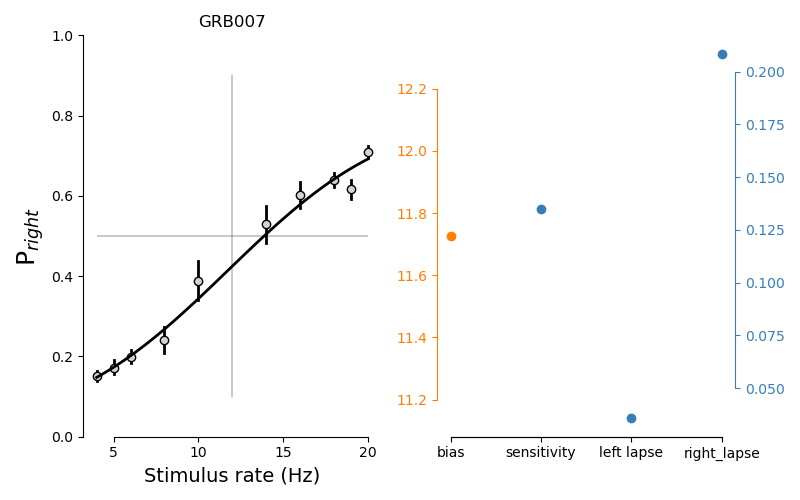

In [74]:
import seaborn as sns
import ptitprince as pt
from ipywidgets import interact, IntSlider, Dropdown, ToggleButton #thanks Lillian!


def separate_twinx(ax): #thanks Lukas!
    ax.spines['top'].set_visible(False)
    ax.spines['left'].set_visible(False)
    yti = ax.get_yticks()
    yti = yti[(yti >= ax.get_ylim()[0]) & (yti <= ax.get_ylim()[1]+10**-3)] #Add a small value to cover for some very tiny added values
    ax.spines['right'].set_bounds([yti[0], yti[-1]])
    xti = ax.get_xticks()
    xti = xti[(xti >= ax.get_xlim()[0]) & (xti <= ax.get_xlim()[1]+10**-3)]
    ax.spines['bottom'].set_bounds([xti[0], xti[-1]])

    return


fig, axs = plt.subplots(1, 2, figsize=(8, 5))
twinx_ax1 = axs[1].twinx()


@interact(ianimal=IntSlider(min=0, max=len(animal_ids)-1, step=1, value=6), 
          min_stims=Dropdown(options=[2,4,5,6,8,10],value=6,description='Minimum stimuli presented:'), 
          stims_equal=False)
def p(stims_equal, ianimal, min_stims):
    axs[0].clear()
    axs[1].clear()
    twinx_ax1.clear()

    animal = animal_ids[ianimal]
    if stims_equal == True:
        stimsequal = 'yes'
    else:
        stimsequal = 'no'
        
    res = psychometric_results[stimsequal][min_stims][animal]

    if not res:
        axs[0].text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=axs[0].transAxes, fontsize=20)
        axs[0].set_title(animal)
    else:
        for s,c in zip(res['stims'],res['p_side_ci']):
            axs[0].plot(s*np.array([1,1]),c, linestyle='-', linewidth=2, color='k')
        axs[0].plot(res['stims'],res['p_side'],'o',markerfacecolor = 'lightgray',markersize = 6, color='k')

        nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
        axs[0].plot(nx,res['function'](*res['fit_params'],nx), linewidth=2, color='k')
        axs[0].set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
        axs[0].set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
        axs[0].set_ylim(0, 1)
        axs[0].set_title(animal)
        axs[0].vlines(12,0.1,0.9,color = 'k',lw = 0.3)
        axs[0].hlines(0.5,np.min(res['stims']),np.max(res['stims']),color = 'k',lw = 0.3)

        #now plot the bias
        # twinx_ax2 = axs[1].twinx()
        # sns.scatterplot(ax=axs[1], data=res['fit_params'][:1], color='k')
        # sns.scatterplot(ax=twinx_ax1, data=res['fit_params'][1:4], color='k')
        # axs[1].set_xticks([0,1,2,3], labels = ['bias', 'sensitivity', 'left lapse', 'right_lapse'])
        # # axs[1].set_xlabel()
        axs[1].scatter(0, res['fit_params'][0], color='#ff7f00') #orange colorblind friendly

        for i in range(1, 4):
            twinx_ax1.scatter([i], res['fit_params'][i], color='#377eb8') #blue colorblind friendly

        axs[1].set_xticks([0,1,2,3])
        axs[1].set_xticklabels(['bias', 'sensitivity', 'left lapse', 'right_lapse'])

        axs[1].spines['left'].set_color('#ff7f00')
        axs[1].tick_params(axis = 'y', color='#ff7f00', which='both', labelcolor='#ff7f00')
        # axs[1].yaxis.set_label_text(color='#ff7f00')
        # axs[1].set_yticklabels(color='red')

        twinx_ax1.spines['right'].set_color('#377eb8')
        twinx_ax1.tick_params(axis = 'y', color='#377eb8', which='both', labelcolor='#377eb8')
        twinx_ax1.yaxis.label.set_color('#377eb8')

    for ax in axs:
        separate_axes(ax)
    separate_twinx(twinx_ax1)

    plt.tight_layout()

    return

#colorblind friendly palette for later use
# colors = {
#     'blue':    '#377eb8', 
#     'orange':  '#ff7f00',
#     'green':   '#4daf4a',
#     'pink':    '#f781bf',
#     'brown':   '#a65628',
#     'purple':  '#984ea3',
#     'gray':    '#999999',
#     'red':     '#e41a1c',
#     'yellow':  '#dede00'
# } 


## Response time and performance comparisons in single sessions

In [152]:
def get_perf_and_response_time_all_animals(animal_ids):
    performance = {}
    response_times = {}

    for animal in animal_ids:
        performance[animal] = {}
        response_times[animal] = {}
        session_files = paths_all_animals[animal]
        for session_file in session_files:
            split_path = session_file.split('/')
            date = split_path[5]
            session_data = pd.read_hdf(session_file)
            sel = session_data[session_data.response_side.isin([0,1])] # select only trials where the subject responded
            responded_right = np.array(sel.response_side == 1).astype(int) # select the response = 1 (i.e. the right side) and cast to integer datatype (number)   
            sel_stim_rates = sel.stimulus_event_timestamps.str.len()
            response_period = np.zeros((len(session_data), 2))
            response_period[:, 0] = [trial[1] for trial in session_data.DemonWaitForWithdrawalFromCenter]
            response_period[:, 1] = [trial[1] for trial in session_data.DemonWaitForResponse]
            
            if date not in performance[animal]:
                performance[animal][date] = {'stims': sel_stim_rates, 'choices': responded_right}
                response_times[animal][date] = [np.diff(trial) for trial in response_period if not np.isnan(trial[0]) and not np.isnan(trial[1])]
            else:
                performance[animal][date]['stims'] = np.concatenate((performance[animal][date]['stims'], sel_stim_rates))
                performance[animal][date]['choices'] = np.concatenate((performance[animal][date]['choices'], responded_right))



    return performance, response_times

performance, response_times = get_perf_and_response_time_all_animals(animal_ids)

interactive(children=(IntSlider(value=6, description='animal', max=12), IntSlider(value=123, description='date…

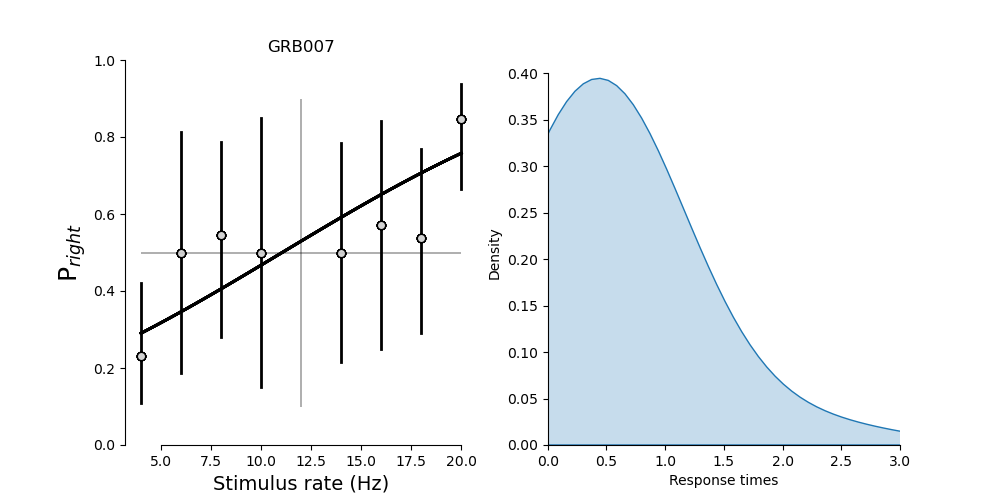

In [153]:
from ipywidgets import interact, IntSlider

fig, ax = plt.subplots(1, 2, figsize=(10, 5))

animal_slider = IntSlider(min=0, max=len(animal_ids)-1, step=1, value=6, description='animal')
date_slider = IntSlider(description='date')

def update_date_range(*args): #this is needed because each animal has a unique number of sessions so the values in the date slider have to change dynamically
    max_date = len(performance[animal_ids[animal_slider.value]])-1
    date_slider.max = max_date
    date_slider.value = max_date  #set the initial value to the last session for practical purposes

animal_slider.observe(update_date_range, 'value') #this makes sure that the date slider is updated anytime the animal slider changes
update_date_range() #called once just to make sure the range is correct when the sliders are initialized for the first animal since the date slider is only updated when the animal slider changes

@interact(ianimal=animal_slider, session_date=date_slider, minstims=IntSlider(min=2, max=12, step=1, value=6))
def h(ianimal, session_date, minstims):
    animal = animal_ids[ianimal]
    dates = list(performance[animal].keys())
    date = dates[session_date]
    allstims = performance[animal][date]['stims']
    allchoices = performance[animal][date]['choices']
    res = fit_psychometric(allstims.astype(float),allchoices.astype(float), min_required_stim_values=minstims)
    try:
        ax[0].clear()
        ax[1].clear()
        for s,c in zip(res['stims'],res['p_side_ci']):
            ax[0].plot(s*np.array([1,1]),c, linestyle='-', linewidth=2, color='k')
            ax[0].plot(res['stims'],res['p_side'],'o',markerfacecolor = 'lightgray',markersize = 6, color='k')

            nx = np.linspace(res['stims'].min(),res['stims'].max(),100)
            ax[0].plot(nx,res['function'](*res['fit_params'],nx), linewidth=2, color='k')
            ax[0].set_ylabel('P$_{right}$',fontsize = 18)  # set the y-axis label with latex nomenclature
            ax[0].set_xlabel('Stimulus rate (Hz)', fontsize = 14); # set the x-axis label
            ax[0].set_ylim(0, 1)
            ax[0].set_title(animal)
            ax[0].vlines(12,0.1,0.9,color = 'k',lw = 0.3, alpha=0.2)
            ax[0].hlines(0.5,np.min(res['stims']),np.max(res['stims']),color = 'k',lw = 0.3, alpha=0.2)

        #now plot the response times
        sns.kdeplot(ax=ax[1], data=np.array(response_times[animal][date]), fill=True, bw_adjust = 0.5, label='Response times')
        ax[1].set_xlabel('Response times')
        ax[1].set_ylabel('Density')
        ax[1].set_xlim([0,3])
        ax[1].legend().remove()

    except Exception as e:
        ax[0].clear()
        ax[1].clear()

        ax[0].text(0.5, 0.5, 'No data available', horizontalalignment='center', verticalalignment='center', transform=ax[0].transAxes, fontsize=20)
        ax[0].set_title(animal)   

    separate_axes(ax[0])
    separate_axes(ax[1])

In [119]:
#TODO: make a plot for each animal where I look at the performance on y and then (stim on + 1s) - time when response occurs
# time between stim offset and choice reporting 
# the idea is to see the direct relationship between seeing parts of the stimulus and the performance of the animal

[array([nan]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([0.3882]),
 array([nan]),
 array([nan]),
 array([0.3668]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([0.4086]),
 array([0.5]),
 array([0.3854]),
 array([0.3663]),
 array([0.4029]),
 array([0.403]),
 array([0.4165]),
 array([nan]),
 array([0.4698]),
 array([0.3337]),
 array([nan]),
 array([0.467]),
 array([0.4564]),
 array([nan]),
 array([0.3761]),
 array([0.3948]),
 array([nan]),
 array([nan]),
 array([0.4537]),
 array([0.423]),
 array([0.4488]),
 array([0.3733]),
 array([nan]),
 array([0.477]),
 array([0.415]),
 array([nan]),
 array([1.3504]),
 array([nan]),
 array([0.4257]),
 array([0.4555]),
 array([0.507]),
 array([0.3678]),
 array([0.342]),
 array([0.4013]),
 array([0.5334]),
 array([nan]),
 array([nan]),
 array([nan]),
 array([0.4629]),
 array([0.4264]),
 array([0.4633]),
 array([0.4741]),
 array([0.3271]),
 array([0.3553]),
 array([nan]),
 array([0.4385]),
 array([0.3374]),
 array([0.4063]),
 array([0.5